In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
import lightgbm as lgb
warnings.filterwarnings(action='ignore')

In [3]:
! pip install impyute

In [4]:
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
train_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_err_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_problem_data.csv')
test_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/test_err_data.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/데이콘/data/sample_submission.csv')
train_quality = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_quality_data.csv')
test_quality = pd.read_csv('/content/drive/MyDrive/데이콘/data/test_quality_data.csv')

In [25]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [46]:
train_quality_df = train_quality.drop(['time','fwver'],axis=1)
train_quality_df.head()

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,10000,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,10000,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,10000,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,10000,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


In [47]:
# train_quality 결측치 최빈값 0으로 대체 
train_quality_df.fillna(0,inplace=True)
train_quality_df.isnull().sum()

user_id       0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [15]:
train_quality_df.dtypes

user_id         int64
quality_0     float64
quality_1       int64
quality_2     float64
quality_3       int64
quality_4       int64
quality_5      object
quality_6       int64
quality_7      object
quality_8      object
quality_9      object
quality_10     object
quality_11      int64
quality_12      int64
dtype: object

In [48]:
def string2num(x):
  x = re.sub(r"[^0-9]+",'',str(x))
  if x == '':
    return 0
  else:
    return int(x)

train_quality_df['quality_5'] = train_quality_df['quality_5'].apply(lambda x : string2num(x))
train_quality_df['quality_7'] = train_quality_df['quality_7'].apply(lambda x : string2num(x))
train_quality_df['quality_8'] = train_quality_df['quality_8'].apply(lambda x : string2num(x))
train_quality_df['quality_9'] = train_quality_df['quality_9'].apply(lambda x : string2num(x))
train_quality_df['quality_10'] = train_quality_df['quality_10'].apply(lambda x : string2num(x))

train_quality_df['quality_5'] = train_quality_df['quality_5'].astype('int')
train_quality_df['quality_7'] = train_quality_df['quality_7'].astype('int')
train_quality_df['quality_8'] = train_quality_df['quality_8'].astype('int')
train_quality_df['quality_9'] = train_quality_df['quality_9'].astype('int')
train_quality_df['quality_10'] = train_quality_df['quality_10'].astype('int')

mean_train_quality = train_quality_df.groupby('user_id').agg('mean')
mean_train_quality = mean_train_quality.reset_index()
mean_train_quality

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,0.000000,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.0,0.000,6.000000,0.000000,0.0
1,10002,0.000000,-0.020833,-0.010417,0.0,0.0,0.343750,0.458333,5.750000,0.0,0.125,3.875000,-0.020833,0.0
2,10004,-0.083333,-0.083333,-0.083333,0.0,0.0,0.250000,3.541667,43.500000,0.0,0.000,2.000000,-0.083333,0.0
3,10005,-0.416667,-0.416667,-0.416667,0.0,0.0,0.833333,1.083333,18.000000,0.0,0.000,5.000000,-0.416667,0.0
4,10006,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.111111,1.333333,0.0,0.000,4.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276,24990,0.000000,-0.333333,-0.333333,0.0,0.0,0.416667,-0.333333,0.000000,0.0,0.000,1.000000,-0.333333,0.0
8277,24992,-0.333333,-0.333333,-0.333333,0.0,0.0,0.861111,-0.333333,0.000000,0.0,0.000,6.333333,-0.333333,0.0
8278,24993,-0.291667,-0.291667,-0.291667,0.0,0.0,0.625000,-0.291667,0.000000,0.0,0.000,4.000000,-0.291667,0.0
8279,24995,-0.416667,-0.416667,-0.416667,0.0,0.0,0.625000,-0.416667,0.000000,0.0,0.000,2.500000,-0.416667,0.0


In [19]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [20]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
  error[person_idx-train_user_id_min,err-1] +=1
error

100%|██████████| 16554663/16554663 [00:41<00:00, 398373.99it/s]


array([[  0.,   0.,   8., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 113.,  56.,   1.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  58.,   8.,   5.],
       [  0.,   0.,   0., ...,   6.,   0.,   0.],
       [  0.,   0.,   4., ...,   0.,   0.,   0.]])

In [49]:
problem = np.zeros(15000)
problem[train_problem['user_id'].unique()-train_user_id_min] = 1
problem

array([0., 1., 0., ..., 1., 1., 0.])

In [26]:
train_err['user_id'].unique()

array([10000, 10001, 10002, ..., 24997, 24998, 24999])

In [ ]:
train_err_problem.isnull().sum()

In [ ]:
problem_df = pd.DataFrame({'user_id':train_err['user_id'].unique(),
                           'problem':problem})
train_quality_problem = pd.merge(mean_train_quality, problem_df,on='user_id')
train_quality_problem.drop(['user_id'],axis=1,inplace=True)
# plt.figure(figsize=(12,8))
# sns.heatmap(train_quality_problem.corr(),annot=True)

In [130]:
train_err_df = pd.DataFrame(error)
train_err_df['user_id'] = train_err['user_id'].unique()
train_err_problem = pd.merge(train_err_df, problem_df,on='user_id')
del train_err_problem['user_id']
train_err_problem

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0


In [142]:
corr_err = train_err_problem.corr()
corr_err[corr_err['problem']>0.1]['problem']

14         0.211715
15         0.212896
17         0.259057
18         0.121187
19         0.287503
20         0.114873
25         0.142512
29         0.119862
32         0.123586
35         0.177015
36         0.177654
39         0.147105
problem    1.000000
Name: problem, dtype: float64

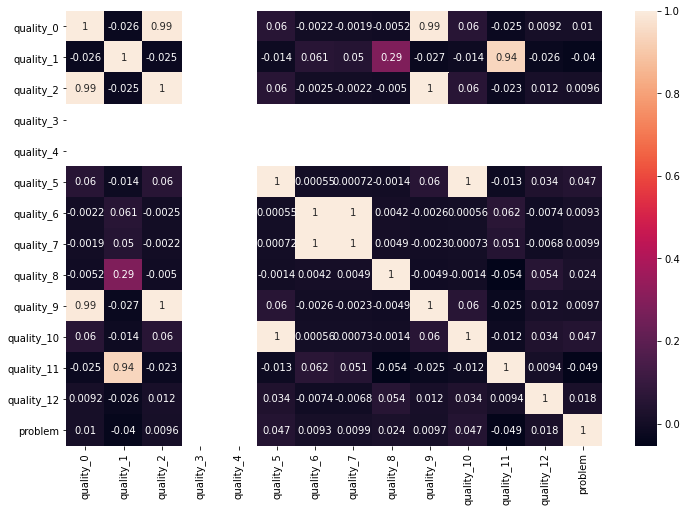

In [54]:
plt.figure(figsize=(12,8))
sns.heatmap(train_quality_problem.corr(),annot=True)

In [56]:
df_error = pd.DataFrame(error)
df_error['user_id'] = train_err['user_id']
df_error

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,user_id
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,10000
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,10000
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,10011
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10011
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,10011
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,10011


In [57]:
merged_train_err_quality = pd.merge(df_error,mean_train_quality,on='user_id',how='left')
del merged_train_err_quality['user_id']
merged_train_err_quality.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0


In [96]:
multiple_imputation_df = pd.DataFrame(IterativeImputer(verbose=False).fit_transform(merged_train_err_quality))
multiple_imputation_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,-0.592126,-0.531088,-0.59244,0.0,0.0,0.801037,-0.184755,4.895993,0.740000,0.003769,2.499384,-0.592755,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.592126,-0.531088,-0.59244,0.0,0.0,0.801037,-0.184755,4.895993,0.739999,0.003768,2.499384,-0.592754,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,-0.592126,-0.531088,-0.59244,0.0,0.0,0.801037,-0.184755,4.895993,0.740000,0.003768,2.499384,-0.592755,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,-0.592126,-0.531088,-0.59244,0.0,0.0,0.801037,-0.184755,4.895993,0.740000,0.003768,2.499384,-0.592755,0.0


In [62]:
multiple_imputation_df.columns

RangeIndex(start=0, stop=55, step=1)

In [97]:
x = StandardScaler().fit_transform(multiple_imputation_df.values)
features = list(range(0,55,1))
pd.DataFrame(x,columns=features).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,-0.196898,-0.030123,0.084345,0.009314,-0.279792,-0.075599,-0.073495,-0.046816,-0.037669,-0.004481,-0.056984,-0.055499,-0.009039,-0.027536,-0.683303,-0.345701,-0.279353,-0.225162,-0.114028,-0.252677,-0.108244,-0.225719,-0.189777,-0.071953,-0.075181,-0.163113,-0.032281,-0.032490,0.0,-0.154519,-0.381844,-0.198957,-1.053094,-0.063401,-0.074263,-1.030661,-1.026064,-0.114398,-0.080135,-0.602484,-0.297800,-0.644056,2.561361,2.631569,2.568722,0.0,0.0,-1.590974,0.187435,-0.49279,-2.050887,-0.214332,3.863032,2.576028,0.0
1,-0.196898,-0.030123,-0.029070,-0.045879,-0.046368,-0.075599,-0.073495,-0.046816,-0.037669,-0.021047,-0.109085,-0.107411,-0.009039,-0.007292,0.626450,0.693337,-0.279353,4.832761,2.461897,5.213885,2.566639,1.146482,0.749306,0.066167,0.877285,-0.596917,-0.033202,-0.033411,0.0,-0.154519,0.339417,-0.198957,-0.168027,0.040010,-0.074263,0.628662,0.622496,-0.114398,-0.080135,0.795711,2.104322,-0.363005,2.561361,2.631569,2.568722,0.0,0.0,-1.590974,0.187435,-0.49279,-2.050887,-0.214332,3.863032,2.576028,0.0
2,-0.196898,-0.030123,-0.000716,0.024173,-0.275388,-0.043639,-0.073495,-0.046816,-0.037669,-0.018681,-0.077824,-0.076264,-0.009039,-0.051828,-0.782958,-0.485273,-0.279353,-0.225162,-0.114028,-0.252677,-0.108244,-0.225719,-0.189777,-0.016705,-0.075181,-0.466776,-0.031360,-0.031569,0.0,-0.154519,-0.381844,-0.198957,-1.053094,-0.063401,-0.074263,-1.030661,-1.026064,-0.114398,-0.080135,-0.602484,-0.297800,-0.644056,2.561361,2.631569,2.568722,0.0,0.0,-1.590974,0.187435,-0.49279,-2.050887,-0.214332,3.863032,2.576028,0.0
3,-0.196898,-0.030123,-0.029070,-0.045879,-0.270984,-0.075599,-0.073495,-0.046816,-0.037669,-0.021047,-0.119505,-0.128176,-0.026327,-0.068023,-0.782958,-0.826450,-0.188277,-0.225162,-0.114028,-0.252677,-0.108244,-0.174896,-0.166018,-0.071953,-0.075181,1.008157,-0.033202,-0.033411,0.0,-0.154519,-0.194316,-0.198957,-0.345040,-0.063401,-0.074263,0.628662,0.622496,0.641705,-0.080135,-0.392136,-0.254905,-0.644056,2.561361,2.631569,2.568722,0.0,0.0,-1.590974,0.187435,-0.49279,-2.050887,-0.214332,3.863032,2.576028,0.0
4,-0.196898,-0.030123,-0.029070,-0.045348,-0.279792,-0.011680,0.015908,-0.046816,-0.037669,-0.021047,-0.046564,-0.024351,0.025536,-0.047779,0.512559,0.119540,-0.279353,-0.225162,-0.114028,-0.252677,-0.108244,0.028393,-0.040974,-0.071953,-0.075181,-0.119733,-0.033202,-0.033411,0.0,-0.154519,0.125924,-0.198957,0.363013,-0.063401,-0.074263,0.628662,0.622496,-0.114398,-0.080135,-0.552991,-0.297800,-0.081954,2.561361,2.631569,2.568722,0.0,0.0,-1.590974,0.187435,-0.49279,-2.050887,-0.214332,3.863032,2.576028,0.0


In [98]:
pca = PCA(n_components=30)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents)
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,5.820057,-1.854410,-0.209018,0.721217,-0.111626,-0.134273,-0.204523,0.688768,-2.543124,-0.500119,-0.200989,0.276803,-0.237923,-0.222943,-0.129377,0.169615,-0.045964,-0.311341,-0.231826,0.151197,-0.012019,0.293663,0.323584,0.108886,-0.116385,0.443640,-2.669983,-0.130003,0.021044,0.058031
1,5.709081,5.213246,-0.904586,5.710392,0.002535,0.666021,-0.206450,0.255642,-2.477745,-0.501526,0.628971,-0.492007,0.545043,0.094812,-0.245815,0.273409,0.638274,-0.108864,-0.344803,-0.016771,1.183241,0.481844,1.746215,0.216220,0.292547,0.784082,-2.575103,0.808926,0.218706,0.279023
2,5.820928,-2.013150,-0.281312,0.814509,-0.046187,-0.122145,-0.240549,0.575410,-2.549930,-0.462465,-0.147898,0.221286,-0.213347,-0.203092,-0.128984,0.165570,-0.025971,-0.303367,-0.258646,0.141549,-0.028076,0.283244,0.351057,0.116545,-0.064315,0.507687,-2.654135,-0.107839,0.064372,0.095527
3,5.826393,-0.360332,-0.216107,-0.164955,0.000563,-0.422410,-0.214538,-1.060222,-2.704619,0.285831,-0.538999,-0.035749,-0.083771,-0.272488,-0.062151,0.181155,0.025159,-0.249634,-0.414231,0.197915,-0.175484,0.350700,0.407202,0.138771,-0.043800,0.476244,-2.549444,-0.154010,-0.217039,0.153318
4,5.819080,0.295933,-0.088744,-0.516027,-0.083201,-0.179861,-0.028781,-0.368272,-2.607933,-0.295995,-0.108500,-0.511086,-0.032423,0.120211,-0.143937,0.068839,0.354159,-0.410283,-0.630601,0.156800,-0.328749,0.355727,0.395145,0.108984,-0.095686,0.395332,-2.536717,-0.178394,-0.306311,-0.228202


In [99]:
pca.explained_variance_ratio_

array([0.14640484, 0.08337781, 0.06118005, 0.05910489, 0.04993927,
       0.04173709, 0.04115971, 0.03299559, 0.02593705, 0.02492386,
       0.0214836 , 0.0207733 , 0.02021626, 0.01987411, 0.01974351,
       0.01946407, 0.01939783, 0.01922806, 0.01918847, 0.01841031,
       0.01828083, 0.01777444, 0.01774817, 0.0176225 , 0.01744518,
       0.0165822 , 0.01608919, 0.01544465, 0.01488423, 0.01410386])

In [100]:
sum(pca.explained_variance_ratio_)

0.93051492875296

In [101]:
train_x = principalDf.values
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 30)
(15000,)


In [ ]:
# dtrain = xgb.DMatrix(data=train_x,label=train_y)

In [116]:
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 50
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

Training until validation scores don't improve for 50 rounds.
[20]	valid_0's auc: 0.779066	valid_0's pr_auc: 0.760067
[40]	valid_0's auc: 0.780736	valid_0's pr_auc: 0.772329
[60]	valid_0's auc: 0.7797	valid_0's pr_auc: 0.77014
[80]	valid_0's auc: 0.779185	valid_0's pr_auc: 0.770117
Early stopping, best iteration is:
[46]	valid_0's auc: 0.781524	valid_0's pr_auc: 0.77253
Training until validation scores don't improve for 50 rounds.
[20]	valid_0's auc: 0.781248	valid_0's pr_auc: 0.318835
[40]	valid_0's auc: 0.782937	valid_0's pr_auc: 0.368553
[60]	valid_0's auc: 0.783969	valid_0's pr_auc: 0.369983
[80]	valid_0's auc: 0.783342	valid_0's pr_auc: 0.370698
Early stopping, best iteration is:
[45]	valid_0's auc: 0.785545	valid_0's pr_auc: 0.370928
Training until validation scores don't improve for 50 rounds.
[20]	valid_0's auc: 0.746534	valid_0's pr_auc: 0.345858
[40]	valid_0's auc: 0.75012	valid_0's pr_auc: 0.365971
[60]	valid_0's auc: 0.747839	valid_0's pr_auc: 0.358998
[80]	valid_0's auc: 0

In [117]:
# 교차검증 점수 확인
print(np.mean(auc_scores))

0.7788769833417097


In [118]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [79]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
  test_x[person_idx-test_user_id_min,err-1]+=1
test_x = test_x.reshape(test_x.shape[0],-1)
test_x.shape

100%|██████████| 16532648/16532648 [00:39<00:00, 423165.39it/s]


(14999, 42)

In [80]:
test_quality_df = test_quality.drop(['time','fwver'],axis=1)
test_quality_df.isnull().sum()

user_id            0
quality_0     106584
quality_1         11
quality_2      21115
quality_3          0
quality_4          0
quality_5         44
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

In [81]:
test_quality_df['quality_1'] = test_quality_df['quality_1'].apply(lambda x : string2num(x))
test_quality_df['quality_5'] = test_quality_df['quality_5'].apply(lambda x : string2num(x))
test_quality_df['quality_7'] = test_quality_df['quality_7'].apply(lambda x : string2num(x))
test_quality_df['quality_8'] = test_quality_df['quality_8'].apply(lambda x : string2num(x))
test_quality_df['quality_9'] = test_quality_df['quality_9'].apply(lambda x : string2num(x))
test_quality_df['quality_10'] = test_quality_df['quality_10'].apply(lambda x : string2num(x))

test_quality_df['quality_1'] = test_quality_df['quality_1'].astype('int')
test_quality_df['quality_5'] = test_quality_df['quality_5'].astype('int')
test_quality_df['quality_7'] = test_quality_df['quality_7'].astype('int')
test_quality_df['quality_8'] = test_quality_df['quality_8'].astype('int')
test_quality_df['quality_9'] = test_quality_df['quality_9'].astype('int')
test_quality_df['quality_10'] = test_quality_df['quality_10'].astype('int')

In [82]:
test_quality_df.fillna(0,inplace=True)
test_quality_df.isnull().sum()

user_id       0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [83]:
mean_test_quality = test_quality_df.groupby('user_id').agg('mean')
mean_test_quality = mean_test_quality.reset_index()
mean_test_quality

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,30000,0.000000,0.000000,0.000000,0.0,0.0,0.166667,0.416667,5.00,0.0,0.00,2.000000,0.000000,0.0
1,30001,-0.250000,0.250000,-0.250000,0.0,0.0,71.444444,-0.250000,0.00,0.0,0.00,854.333333,-0.250000,0.0
2,30002,-0.125000,0.125000,-0.125000,0.0,0.0,1.233333,-0.125000,0.00,0.0,0.00,13.300000,-0.125000,0.0
3,30003,0.000000,0.000000,0.000000,0.0,0.0,0.200000,3.666667,44.00,0.0,0.00,2.400000,0.000000,0.0
4,30004,-0.250000,0.250000,-0.250000,0.0,0.0,0.333333,1.125000,16.50,0.0,0.00,1.000000,-0.250000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8263,44990,-0.111111,0.111111,-0.111111,0.0,0.0,1.500000,-0.111111,0.00,0.0,0.00,16.666667,-0.111111,0.0
8264,44993,0.145833,0.041667,0.145833,0.0,0.0,0.333333,2.229167,27.25,0.0,2.25,3.500000,-0.041667,0.0
8265,44994,-0.916667,0.916667,-0.916667,0.0,0.0,1.083333,-0.916667,0.00,0.0,0.00,2.000000,-0.916667,0.0
8266,44996,-0.046296,0.046296,-0.046296,0.0,0.0,0.388889,-0.046296,0.00,0.0,0.00,4.111111,-0.046296,0.0


In [84]:
df_error_test = pd.DataFrame(test_x)
df_error_test['user_id'] = test_err['user_id']
df_error_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,user_id
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0,30000
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0,30000
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0,30000
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,123.0,93.0,12.0,0.0,0.0,0.0,0.0,197.0,204.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,179.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,87.0,0.0,30015
14995,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,15.0,1.0,4.0,149.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,183.0,0.0,14.0,1.0,0.0,1.0,1.0,0.0,0.0,12.0,17.0,0.0,30015
14996,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,12.0,13.0,1.0,3.0,129.0,90.0,2.0,0.0,0.0,0.0,0.0,138.0,165.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,163.0,0.0,12.0,1118.0,0.0,1.0,1.0,1.0,0.0,329.0,2.0,3.0,30015
14997,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,0.0,15.0,16.0,0.0,1.0,73.0,44.0,0.0,1.0,0.0,1.0,0.0,11127.0,13161.0,0.0,3.0,44.0,0.0,0.0,0.0,0.0,78.0,0.0,14.0,0.0,0.0,1.0,1.0,3.0,0.0,30.0,49.0,0.0,30015


In [85]:
merged_test_err_quality = pd.merge(df_error_test,mean_test_quality,on='user_id',how='left')
del merged_test_err_quality['user_id']
merged_test_err_quality.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0


In [86]:
multiple_imputation_df_test = pd.DataFrame(IterativeImputer(verbose=False).fit_transform(merged_test_err_quality))
multiple_imputation_df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.416667,5.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,123.0,93.0,12.0,0.0,0.0,0.0,0.0,197.0,204.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,179.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,87.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,1.833333,22.0,1.0,0.0,0.0,0.0,0.0
14995,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,15.0,1.0,4.0,149.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,183.0,0.0,14.0,1.0,0.0,1.0,1.0,0.0,0.0,12.0,17.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,1.833333,22.0,1.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,12.0,13.0,1.0,3.0,129.0,90.0,2.0,0.0,0.0,0.0,0.0,138.0,165.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,163.0,0.0,12.0,1118.0,0.0,1.0,1.0,1.0,0.0,329.0,2.0,3.0,0.0,0.083333,0.0,0.0,0.0,0.000000,1.833333,22.0,1.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,0.0,15.0,16.0,0.0,1.0,73.0,44.0,0.0,1.0,0.0,1.0,0.0,11127.0,13161.0,0.0,3.0,44.0,0.0,0.0,0.0,0.0,78.0,0.0,14.0,0.0,0.0,1.0,1.0,3.0,0.0,30.0,49.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,1.833333,22.0,1.0,0.0,0.0,0.0,0.0


In [119]:
x = StandardScaler().fit_transform(multiple_imputation_df_test.values)
features = list(range(0,55,1))
pd.DataFrame(x,columns=features).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,-0.195744,-0.031265,-0.053584,-0.024235,0.004866,-0.076573,-0.076970,-0.047343,-0.056715,-0.025021,-0.019352,-0.085303,-0.096747,-0.045584,-0.580398,-0.723975,0.217110,2.989508,-0.085127,1.097021,-0.078318,1.435049,1.084125,0.062679,2.92463,-0.156236,-0.034552,-0.034833,0.0,-0.153472,-0.056705,-0.194513,0.346428,-0.065632,0.016874,3.792101,3.765437,-0.133966,0.040200,0.539586,-0.347358,-0.081558,1.614955,-1.602328,1.601724,0.0,0.0,-0.834352,0.024029,-0.286371,-0.520426,0.0,-0.831926,1.606121,-0.333128
1,-0.195744,-0.031265,0.049534,0.005791,-0.220379,0.006625,0.006359,-0.047343,-0.056715,-0.025021,-0.032687,-0.085303,0.319519,-0.037345,-0.781219,-0.443906,-0.121921,-0.202834,-0.085127,-0.190174,-0.078318,-0.212542,-0.155463,-0.081366,-0.11585,-0.503358,-0.033321,-0.033603,0.0,-0.153472,-0.139871,-0.199937,-1.000969,-0.065632,-0.075328,-1.005008,-1.000353,-0.133966,-0.086726,-0.602543,-0.347358,-0.644892,1.614955,-1.602328,1.601724,0.0,0.0,-0.834352,0.024029,-0.286371,-0.520426,0.0,-0.831926,1.606121,-0.333128
2,-0.195744,-0.031265,-0.053584,-0.024235,0.069767,-0.048840,-0.076970,-0.047343,-0.056715,-0.025021,-0.019352,-0.085303,-0.096747,-0.051077,0.940100,0.769727,-0.121921,-0.202834,-0.085127,-0.190174,-0.078318,-0.111977,-0.117555,-0.023748,-0.11585,0.190887,-0.034552,-0.034833,0.0,-0.153472,0.090589,-0.199937,0.346428,-0.065632,-0.075328,0.594028,0.588244,-0.133966,0.801754,0.800289,-0.299226,-0.081558,1.614955,-1.602328,1.601724,0.0,0.0,-0.834352,0.024029,-0.286371,-0.520426,0.0,-0.831926,1.606121,-0.333128
3,-0.195744,-0.031265,-0.053584,-0.024235,0.176663,-0.048840,-0.049194,-0.047343,-0.056715,-0.025021,-0.059357,-0.304713,0.007320,-0.034598,-1.426713,-1.112960,-0.121921,0.861280,-0.085127,1.097021,-0.078318,-0.207513,-0.153568,-0.081366,-0.11585,-1.327774,-0.032090,-0.032372,0.0,-0.153472,-0.005603,-0.199937,-0.664120,0.034604,0.201278,0.594028,0.588244,-0.133966,-0.086726,-0.105965,0.037700,-0.644892,1.614955,-1.602328,1.601724,0.0,0.0,-0.834352,0.024029,-0.286371,-0.520426,0.0,-0.831926,1.606121,-0.333128
4,-0.195744,-0.031265,-0.053584,-0.023622,-0.208926,-0.076573,-0.076970,-0.047343,-0.056715,-0.025021,-0.039355,-0.165088,0.007320,-0.004387,-0.393922,-0.257193,0.104100,-0.202834,-0.085127,-0.190174,-0.078318,-0.195781,-0.147882,-0.081366,-0.11585,-0.937261,-0.033321,-0.033603,0.0,-0.153472,0.192793,0.212281,-0.074634,-0.028044,0.016874,0.594028,0.588244,0.288700,-0.086726,-0.006650,3.984542,-0.644892,1.614955,-1.602328,1.601724,0.0,0.0,-0.834352,0.024029,-0.286371,-0.520426,0.0,-0.831926,1.606121,-0.333128


In [120]:
pca = PCA(n_components=30)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents)
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,3.716755,3.624458,0.286268,-0.214199,-0.243606,-0.004049,-0.381549,0.304206,4.676629,0.407312,-0.510701,0.881484,0.117312,1.204061,-0.851682,-0.029038,-0.896229,0.609555,0.164546,0.265931,-0.608565,-0.873031,0.119549,0.740207,-1.376429,-1.599060,0.499127,0.883274,-0.257448,0.060233
1,3.272692,-1.924178,1.371344,0.248808,-0.134268,-0.063202,-0.272355,-0.006334,-0.476604,-0.143099,-0.494243,-0.277349,-0.129473,-0.080245,0.062387,-0.087023,0.134067,-0.280759,-0.045237,0.001521,0.026464,0.234160,-0.174389,0.101056,0.121009,-0.233586,0.141514,0.191937,0.162337,0.146697
2,3.528355,0.621752,-1.019355,-0.361036,-0.100481,0.227915,0.139599,-0.170070,-0.357023,-0.065454,-0.559086,0.155268,-0.351286,0.343853,-0.078920,-0.025916,-0.004809,0.246265,0.398399,0.103504,-0.627446,0.188004,-0.170403,0.409347,-0.208288,0.067419,-0.104259,-0.224978,0.404130,0.071673
3,3.374676,-0.515048,1.722192,0.061667,-0.186818,-0.309900,-0.488766,-0.576767,1.538189,-0.119131,-0.484573,0.216333,-0.077911,0.090697,0.122973,-0.460196,-0.203522,0.251996,-0.039352,0.053816,0.052282,-0.270510,0.328530,0.310903,0.028361,0.161356,-0.072116,0.353598,0.383100,0.095585
4,3.474123,-0.131276,-0.247142,-0.158896,-0.153134,-0.101588,-0.120067,-0.305230,0.665586,-0.187081,-0.568296,0.354811,0.033509,0.161614,0.061183,0.021335,0.184945,0.005626,-0.371105,-0.214345,1.066692,-0.871834,2.913047,-0.665409,1.467150,0.131097,-0.716315,1.471496,0.999191,0.483554


In [121]:
pca.explained_variance_ratio_

array([0.09313108, 0.08480124, 0.06559856, 0.05878554, 0.05095765,
       0.04797633, 0.03999847, 0.03834382, 0.0327718 , 0.02687315,
       0.02467732, 0.02338202, 0.02189628, 0.02104964, 0.02071583,
       0.02021244, 0.01990548, 0.0196616 , 0.0194395 , 0.01923209,
       0.01910703, 0.01878299, 0.01812221, 0.01739212, 0.01683358,
       0.0162896 , 0.015775  , 0.01547906, 0.01516129, 0.01468191])

In [122]:
sum(pca.explained_variance_ratio_)

0.9170346252524781

In [123]:
# 예측
pred_y_list =[]
for model in models:
  pred_y = model.predict(principalDf.values)
  pred_y_list.append(pred_y.reshape(-1,1))
pred_ensemble = np.mean(pred_y_list,axis=0)
pred_ensemble

array([[0.84695962],
       [0.28754887],
       [0.50447586],
       ...,
       [0.76948558],
       [0.80384772],
       [0.46788145]])

In [124]:
pred = np.where(pred_ensemble>threshold, 1,0)
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
sample_submission.head(2)

,user_id,problem
0,30000,0
1,30001,0


In [125]:
sample_submission['problem'] = pred
sample_submission.head()

,user_id,problem
0,30000,1
1,30001,0
2,30002,1
3,30003,0
4,30004,0


In [126]:
sample_submission.to_csv('/content/drive/MyDrive/데이콘/submission/lgb_kfold5_earlystopping50_pca30_submission_threshold0.5.csv')